# Pneumonia Detection from Chest X-ray through Deep Learning

## I. Overview

## II. Business Problem

## III. Data Understanding and Preparation
- The datasets acquired from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) were downloaded in a "chest_xray" folder. This folder has 3 sub-folders inside which are "train", "test", and "val". Each sub-folder contains 2 sub-folders: "NORMAL" and "PNEUMONIA"

In [1]:
import os

import pandas as pd
import numpy as np
np.random.seed(24)
# Set for displaying prediction probability for later
np.set_printoptions(precision=6, suppress=True)  # if absolute value < 1e-4, set equal to 0

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from google.colab import drive

In [4]:
from tensorflow import random
random.set_seed(24)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Implementation of the scikit-learn classifier API for Keras
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [6]:
# Get the current working directory
print(os.getcwd())

/content


In [7]:
# Drive path is the path where I upload the zip file
drive_path = '/gdrive/MyDrive/chest_xray.zip'

# Expect to move the zip file into the local path
local_path = '/content'

In [8]:
# Copy the file in drive path
!cp '{drive_path}' .

# Change the file from drive path to the local path
os.chdir(local_path)

# Unzip the file
!unzip -q 'chest_xray.zip'

In [9]:
# Check the number of images in each sub-folders

# Train
train_normal = '/content/chest_xray/train/NORMAL'
train_pneumonia = '/content/chest_xray/train/PNEUMONIA'

print("Train Normal:", len(os.listdir(train_normal)))
print("Train Pneumonia:", len(os.listdir(train_pneumonia)))
print("Train Total:", len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia)))

# Test
test_normal = '/content/chest_xray/test/NORMAL'
test_pneumonia = '/content/chest_xray/test/PNEUMONIA'

print("\nTest Normal:", len(os.listdir(test_normal)))
print("Test Pneumonia:", len(os.listdir(test_pneumonia)))
print("Test Total:", len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia)))

# Validation
val_normal = '/content/chest_xray/val/NORMAL'
val_pneumonia = '/content/chest_xray/val/PNEUMONIA'

print("\nVal Normal:", len(os.listdir(val_normal)))
print("Val Pneumonia:", len(os.listdir(val_pneumonia)))
print("Val Total:", len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia)))

Train Normal: 1341
Train Pneumonia: 3875
Train Total: 5216

Test Normal: 234
Test Pneumonia: 390
Test Total: 624

Val Normal: 8
Val Pneumonia: 8
Val Total: 16


In [10]:
# Create file directory
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

In [11]:
# Create data generator
# Get all the train data (5216), test data (624), validation data (16) in the corresponding directory
# Scale data
# Set each image to 128×128 px
# Set binary class mode

train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216, class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624, class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16, class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
# Create the data sets
# next - retrieve the next item from iterator
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [13]:
# Check the shape
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))

print ("\nX_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

print ("\nX_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

X_train shape: (5216, 128, 128, 3)
y_train shape: (5216,)

X_test shape: (624, 128, 128, 3)
y_test shape: (624,)

X_val shape: (16, 128, 128, 3)
y_val shape: (16,)


In [14]:
# Check if the binary indicator was correctly labeled
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
# Create two lists for storing the image number from validation set
normal_img_num = []
pneumonia_img_num = []

# Validation set only contains 16 images
# target label = 0 means normal
# target label = 1 means pneumonis

numbers = list(range(0,16))
for num in numbers:
    
    if y_val[num] == 0:
        normal_img_num.append(num)
    
    else:
        pneumonia_img_num.append(num)

print(normal_img_num)
print(pneumonia_img_num)

[1, 3, 5, 6, 8, 9, 12, 14]
[0, 2, 4, 7, 10, 11, 13, 15]


0.0
1.0


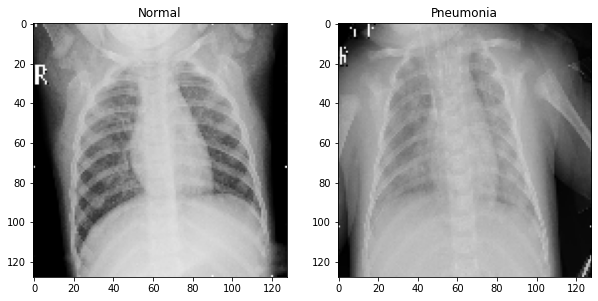

In [16]:
# Plot one image from each list 
# Choose the 1st image from each list
fig = plt.figure(figsize=(10,10))
n = 0

# Normal
ax1 = fig.add_subplot(121)
plt.imshow(X_val[normal_img_num[n]])
print(y_val[normal_img_num[n]])
plt.title("Normal");

# Pneumonia
ax2 = fig.add_subplot(122)
plt.imshow(X_val[pneumonia_img_num[n]])
print(y_val[pneumonia_img_num[n]])
plt.title("Pneumonia");

In [17]:
def visualize_training_results(history):
    '''
    Input: keras history object 
    
    '''
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [18]:
def model_evaluation(model):
    '''
    Input: keras model
    
    Append accuracy results
    
    Plot confusion matrix
    '''
    
    train_acc = []
    test_acc = []
    
    # Train loss and accuracy
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    train_acc.append(round(result_train[1], 4))
    
    # Test loss and accuracy
    result_test = model.evaluate(X_test, y_test)
    print(f'Test Loss:{result_test[0]:.4}')
    print(f'Test Accuracy:{result_test[1]:.4}')
    test_acc.append(round(result_test[1], 4))
    
    # Prediction
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    ax.set_ylim(2,0)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()
    
    # Classification Report
    print(classification_report(y_test, y_test_pred))
    
    return train_acc, test_acc

### Note:
- Since the <u>*validation set*</u> contains much less data than the <u>*test set*</u>, I will use the <u>*test set*</u> as my validation during the model fit step
- <u>*validation set*</u> will be used as true holdout which only use at the end 

### Problem of small validation set
- If the validation set contains much less data than training set, the validation curves (accuracy and loss) will be spiky before convergence. In other words, more epochs and longer training time will be required

## IV. Modeling

### CNN Baseline Model

In [19]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [21]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 16ms/step - loss: 0.2261 - accuracy: 0.9089 - val_loss: 0.7923 - val_accuracy: 0.7564
Epoch 2/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0990 - accuracy: 0.9649 - val_loss: 0.6141 - val_accuracy: 0.7837
Epoch 3/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0956 - accuracy: 0.9655 - val_loss: 1.0894 - val_accuracy: 0.7452
Epoch 4/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0782 - accuracy: 0.9709 - val_loss: 0.8628 - val_accuracy: 0.7997
Epoch 5/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0552 - accuracy: 0.9799 - val_loss: 1.0802 - val_accuracy: 0.7772
Epoch 6/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0451 - accuracy: 0.9839 - val_loss: 1.6465 - val_accuracy: 0.7308
Epoch 7/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0313 - accuracy: 0.9893 - val_loss: 1.3960 - val_accuracy: 0.7724

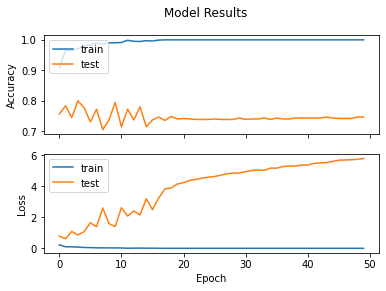

In [22]:
visualize_training_results(base_history)

In [23]:
base_model.save('/content/saved_models/base_model.h5')

163/163 [==============================] - 1s 7ms/step - loss: 1.2432e-06 - accuracy: 1.0000
Training Loss:1.243e-06
Training Accuracy:1.0
20/20 [==============================] - 0s 9ms/step - loss: 5.7993 - accuracy: 0.7468
Test Loss:5.799
Test Accuracy:0.7468


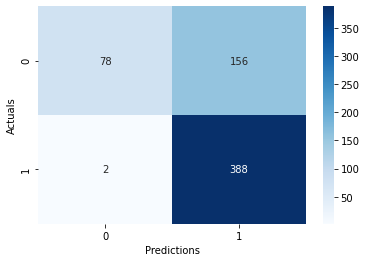

              precision    recall  f1-score   support

         0.0       0.97      0.33      0.50       234
         1.0       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.71       624



([1.0], [0.7468])

In [24]:
base = load_model('/content/saved_models/base_model.h5')
bm = model_evaluation(base)
bm

>**Comment:** *Baseline Model*
- The CNN baseline model took more than 40 minutes to run
- The train accuracy (100%) is higher than val accuracy (0.753) which indicates that the baseline model is overfit
- The accuracy plot shows that test accuracy reaches convergence after 20 epochs 
- The loss plot shows that test loss still increase after 20 epochs
- Early stopping can be used for iteration model tunning to prevent overfit and saving time
- There are more false positive than false negative

### Early Stopping

In [25]:
# Early Stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=6)

### Solve Overfitting Technique
1. Dropout
2. Regularization, L1, L2, L1+L2

### Grid Search for dropout %

In [31]:
def dropout_model(percent):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

https://faroit.com/keras-docs/1.0.6/scikit-learn-api/

In [32]:
# Wrapper
DP_model = KerasClassifier(build_fn=dropout_model)

In [33]:
# parameter grid
dp_param_grid = {'percent': [0.2, 0.3, 0.4, 0.5]}

DP_grid = GridSearchCV(DP_model, param_grid=dp_param_grid, cv=3)

In [34]:
DP_grid_history = DP_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 20ms/step - loss: 0.6244 - accuracy: 0.7551 - val_loss: 0.6548 - val_accuracy: 0.7420
Epoch 2/50
109/109 [==============================] - 2s 17ms/step - loss: 0.1502 - accuracy: 0.9400 - val_loss: 0.7824 - val_accuracy: 0.7452
Epoch 3/50
109/109 [==============================] - 2s 17ms/step - loss: 0.1228 - accuracy: 0.9533 - val_loss: 0.6096 - val_accuracy: 0.7724
Epoch 4/50
109/109 [==============================] - 2s 17ms/step - loss: 0.1168 - accuracy: 0.9528 - val_loss: 0.5453 - val_accuracy: 0.8061
Epoch 5/50
109/109 [==============================] - 2s 17ms/step - loss: 0.0687 - accuracy: 0.9736 - val_loss: 0.8917 - val_accuracy: 0.7532
Epoch 6/50
109/109 [==============================] - 2s 16ms/step - loss: 0.0628 - accuracy: 0.9781 - val_loss: 1.1591 - val_accuracy: 0.7388
Epoch 7/50
109/109 [==============================] - 2s 17ms/step - loss: 0.0573 - accuracy: 0.9761 - val_loss: 1.1737 - val_accuracy: 0.7452

In [35]:
# Find the best weight_decay value
DP_grid_history.best_params_

{'percent': 0.2}

#### 1) Dropout 20
- Add (20%) dropout layers and earlystopping 

In [ ]:
dropout_20 = dropout_model(0.2)

In [26]:
# dropout_20 = models.Sequential()
# dropout_20.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
# dropout_20.add(layers.MaxPooling2D((2, 2)))
# dropout_20.add(layers.Dropout(0.2))

# dropout_20.add(layers.Conv2D(64, (3, 3), activation='relu'))
# dropout_20.add(layers.MaxPooling2D((2, 2)))
# dropout_20.add(layers.Dropout(0.2))

# dropout_20.add(layers.Conv2D(128, (3, 3), activation='relu'))
# dropout_20.add(layers.MaxPooling2D((2, 2)))
# dropout_20.add(layers.Dropout(0.2))

# dropout_20.add(layers.Flatten())
# dropout_20.add(layers.Dense(128, activation='relu'))
# dropout_20.add(layers.Dense(1, activation='sigmoid'))

# dropout_20.compile(optimizer='adam',
#                    loss='binary_crossentropy',
#                    metrics=['accuracy'])

In [27]:
mc_dp_20 = ModelCheckpoint(filepath='/content/saved_models/dropout_20.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [28]:
dropout_20_history = dropout_20.fit(X_train, y_train,
                                    epochs=50,
                                    batch_size=32,
                                    callbacks=[es, mc_dp_20],
                                    validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 16ms/step - loss: 0.6293 - accuracy: 0.7261 - val_loss: 0.5762 - val_accuracy: 0.7756

Epoch 00001: val_accuracy improved from -inf to 0.77564, saving model to /content/saved_models/dropout_20.h5
Epoch 2/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1283 - accuracy: 0.9502 - val_loss: 0.6231 - val_accuracy: 0.7885

Epoch 00002: val_accuracy improved from 0.77564 to 0.78846, saving model to /content/saved_models/dropout_20.h5
Epoch 3/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1150 - accuracy: 0.9569 - val_loss: 0.7523 - val_accuracy: 0.7628

Epoch 00003: val_accuracy did not improve from 0.78846
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1003 - accuracy: 0.9647 - val_loss: 0.8891 - val_accuracy: 0.7532

Epoch 00004: val_accuracy did not improve from 0.78846
Epoch 5/50
163/163 [==============================] - 2s 15ms/step - loss: 0.0751 - accuracy:

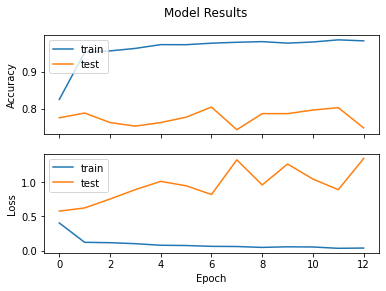

In [29]:
visualize_training_results(dropout_20_history)

163/163 [==============================] - 1s 7ms/step - loss: 0.0539 - accuracy: 0.9785
Training Loss:0.05393
Training Accuracy:0.9785
20/20 [==============================] - 0s 8ms/step - loss: 0.8184 - accuracy: 0.8045
Test Loss:0.8184
Test Accuracy:0.8045


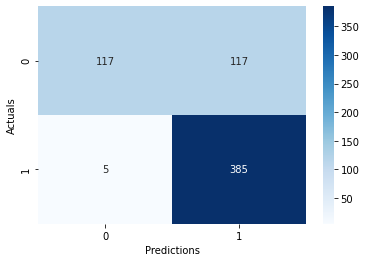

              precision    recall  f1-score   support

         0.0       0.96      0.50      0.66       234
         1.0       0.77      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.76       624
weighted avg       0.84      0.80      0.79       624



([0.9785], [0.8045])

In [30]:
dp20 = load_model('/content/saved_models/dropout_20.h5')
dp20m = model_evaluation(dp20)
dp20m

>**Comment:** Dropout 20%
- The dropout_20 model took less time to run compare with the baseline model
- The train accuracy (0.9659) is higher than test accuracy (0.7997) which indicates the model is overfit 
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative
- dp20 has more FN than base

### Grid Search For L2 weight decay

GridSearch https://heartbeat.fritz.ai/introduction-to-deep-learning-with-keras-c7c3d14e1527

In [41]:
def L2_regularizer_model(weight_decay):
    
    # Build the model with L2 regularizer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [42]:
L2_model = KerasClassifier(build_fn=L2_regularizer_model)

In [43]:
# parameter grid
reg_param_grid = {'weight_decay': [0.5, 0.05, 0.005, 0.0005]}

In [44]:
L2_grid = GridSearchCV(L2_model, param_grid=reg_param_grid, cv=3)

In [45]:
L2_grid_history = L2_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 18ms/step - loss: 28.6440 - accuracy: 0.7588 - val_loss: 0.8412 - val_accuracy: 0.7580
Epoch 2/50
109/109 [==============================] - 2s 16ms/step - loss: 0.4291 - accuracy: 0.9145 - val_loss: 0.7227 - val_accuracy: 0.7452
Epoch 3/50
109/109 [==============================] - 2s 16ms/step - loss: 0.2737 - accuracy: 0.9200 - val_loss: 0.6167 - val_accuracy: 0.7708
Epoch 4/50
109/109 [==============================] - 2s 16ms/step - loss: 0.2799 - accuracy: 0.9236 - val_loss: 0.7038 - val_accuracy: 0.7564
Epoch 5/50
109/109 [==============================] - 2s 16ms/step - loss: 0.2471 - accuracy: 0.9335 - val_loss: 0.6076 - val_accuracy: 0.7853
Epoch 6/50
109/109 [==============================] - 2s 17ms/step - loss: 0.2402 - accuracy: 0.9344 - val_loss: 1.2060 - val_accuracy: 0.6571
Epoch 7/50
109/109 [==============================] - 2s 16ms/step - loss: 0.2649 - accuracy: 0.9255 - val_loss: 0.6807 - val_accuracy: 0.764

In [46]:
# Find the best weight_decay value
L2_grid_history.best_params_

{'weight_decay': 0.005}

#### 2) L2 Regularizer (0.005)

https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/

L2 hyperparameter choosing https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

In [ ]:
L2_reg = L2_regularizer_model(0.005)

In [36]:
# L2_reg = models.Sequential()
# L2_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), 
#                          activation='relu', input_shape=X_train.shape[1:]))
# L2_reg.add(layers.MaxPooling2D((2, 2)))

# L2_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
# L2_reg.add(layers.MaxPooling2D((2, 2)))

# L2_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
# L2_reg.add(layers.MaxPooling2D((2, 2)))

# L2_reg.add(layers.Flatten())
# L2_reg.add(layers.Dense(128, activation='relu'))
# L2_reg.add(layers.Dense(1, activation='sigmoid'))

# L2_reg.compile(optimizer='adam',
#                loss='binary_crossentropy',
#                metrics=['accuracy'])

In [37]:
mc_L2_reg = ModelCheckpoint(filepath='/content/saved_models/L2_reg.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [38]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=[es, mc_L2_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 16ms/step - loss: 0.8248 - accuracy: 0.7854 - val_loss: 0.7667 - val_accuracy: 0.7692

Epoch 00001: val_accuracy improved from -inf to 0.76923, saving model to /content/saved_models/L2_reg.h5
Epoch 2/50
163/163 [==============================] - 2s 15ms/step - loss: 0.2280 - accuracy: 0.9576 - val_loss: 0.9412 - val_accuracy: 0.7628

Epoch 00002: val_accuracy did not improve from 0.76923
Epoch 3/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1819 - accuracy: 0.9608 - val_loss: 0.8173 - val_accuracy: 0.7644

Epoch 00003: val_accuracy did not improve from 0.76923
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1576 - accuracy: 0.9642 - val_loss: 0.7476 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.76923 to 0.79167, saving model to /content/saved_models/L2_reg.h5
Epoch 5/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1228 - accuracy: 0.9715 

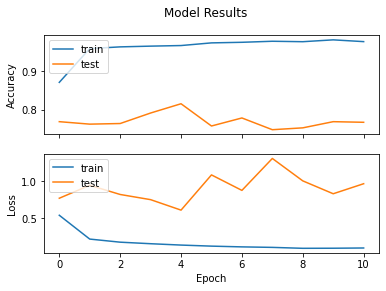

In [39]:
visualize_training_results(L2_reg_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1401 - accuracy: 0.9666
Training Loss:0.1401
Training Accuracy:0.9666
20/20 [==============================] - 0s 8ms/step - loss: 0.6067 - accuracy: 0.8157
Test Loss:0.6067
Test Accuracy:0.8157


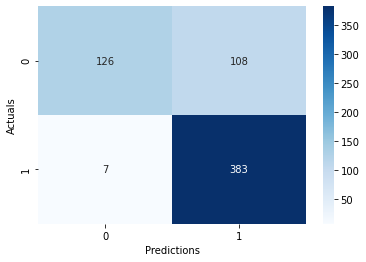

              precision    recall  f1-score   support

         0.0       0.95      0.54      0.69       234
         1.0       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624



([0.9666], [0.8157])

In [40]:
L2 = load_model('/content/saved_models/L2_reg.h5')
L2m = model_evaluation(L2)
L2m

>**Comment:** 
- The L2 took less time to run compare with the baseline model
- The train accuracy (0.9442) is higher than test accuracy (0.8446) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

https://datascience.stackexchange.com/questions/77881/whats-the-difference-between-gridsearchcrossvalidation-score-and-score-on-tests#:~:text=Grid%20search%20trains%20different%20models,score%20of%20the%20best%20estimator.&text=It%20means%20that%20the%20model,not%20on%20the%20unseen%20data.

### Grid Search For L1 weight decay

In [52]:
def L1_regularizer_model(weight_decay):
    
    # Build the model with L2 regularizer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [53]:
L1_model = KerasClassifier(build_fn=L1_regularizer_model)

In [54]:
L1_grid = GridSearchCV(L1_model, param_grid=reg_param_grid, cv=3)

In [55]:
L1_grid_history = L1_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 18ms/step - loss: 726.3731 - accuracy: 0.7468 - val_loss: 8.8447 - val_accuracy: 0.6250
Epoch 2/50
109/109 [==============================] - 2s 16ms/step - loss: 7.1011 - accuracy: 0.7432 - val_loss: 6.4452 - val_accuracy: 0.6250
Epoch 3/50
109/109 [==============================] - 2s 16ms/step - loss: 6.2979 - accuracy: 0.7477 - val_loss: 6.4079 - val_accuracy: 0.6250
Epoch 4/50
109/109 [==============================] - 2s 16ms/step - loss: 6.2940 - accuracy: 0.7428 - val_loss: 6.4158 - val_accuracy: 0.6250
Epoch 5/50
109/109 [==============================] - 2s 16ms/step - loss: 6.2940 - accuracy: 0.7393 - val_loss: 6.4389 - val_accuracy: 0.6250
Epoch 6/50
109/109 [==============================] - 2s 16ms/step - loss: 6.2895 - accuracy: 0.7477 - val_loss: 6.4661 - val_accuracy: 0.6250
Epoch 7/50
109/109 [==============================] - 2s 16ms/step - loss: 6.3028 - accuracy: 0.7342 - val_loss: 6.4340 - val_accuracy: 0.62

In [56]:
# Find the best weight_decay value
L1_grid_history.best_params_

{'weight_decay': 0.0005}

#### 3) L1 Regularizer (0.0005)

In [58]:
L1_reg = L1_regularizer_model(0.0005)

In [59]:
mc_L1_reg = ModelCheckpoint(filepath='/content/saved_models/L1_reg.h5', 
                             monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [60]:
L1_reg_history = L1_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=[es, mc_L1_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 17ms/step - loss: 1.2605 - accuracy: 0.8214 - val_loss: 0.7204 - val_accuracy: 0.8349

Epoch 00001: val_accuracy improved from -inf to 0.83494, saving model to /content/saved_models/L10005.h5
Epoch 2/50
163/163 [==============================] - 2s 14ms/step - loss: 0.3509 - accuracy: 0.9563 - val_loss: 0.9128 - val_accuracy: 0.7708

Epoch 00002: val_accuracy did not improve from 0.83494
Epoch 3/50
163/163 [==============================] - 2s 14ms/step - loss: 0.2403 - accuracy: 0.9616 - val_loss: 0.6915 - val_accuracy: 0.7885

Epoch 00003: val_accuracy did not improve from 0.83494
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.2120 - accuracy: 0.9614 - val_loss: 0.7718 - val_accuracy: 0.7917

Epoch 00004: val_accuracy did not improve from 0.83494
Epoch 5/50
163/163 [==============================] - 2s 14ms/step - loss: 0.1650 - accuracy: 0.9707 - val_loss: 0.8191 - val_accuracy: 0.7853

Epoch 0000

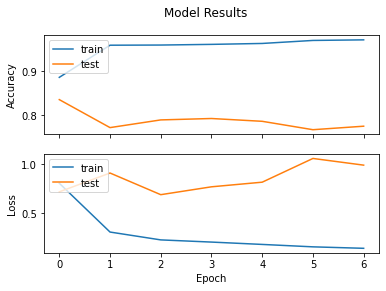

In [62]:
visualize_training_results(L1_reg_history)

163/163 [==============================] - 1s 7ms/step - loss: 0.4185 - accuracy: 0.9371
Training Loss:0.4185
Training Accuracy:0.9371
20/20 [==============================] - 0s 7ms/step - loss: 0.7204 - accuracy: 0.8349
Test Loss:0.7204
Test Accuracy:0.8349


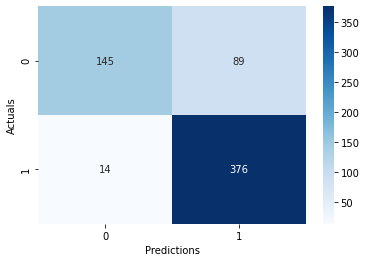

              precision    recall  f1-score   support

         0.0       0.91      0.62      0.74       234
         1.0       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.83       624



([0.9371], [0.8349])

In [63]:
L1 = load_model('/content/saved_models/L1_reg.h5')
L1m = model_evaluation(L1)
L1m

### 4) L1 + L2

In [64]:
def L1_L2_regularizer_model(wd_1, wd_2):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu', input_shape=(128,128,3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [65]:
L_model = KerasClassifier(build_fn=L1_L2_regularizer_model)

In [66]:
# parameter grid
l1l2_param_grid = {'wd_1': [0.5, 0.05, 0.005, 0.0005],
                   'wd_2': [0.5, 0.05, 0.005, 0.0005]}

L_grid = GridSearchCV(L_model, param_grid=l1l2_param_grid, cv=3)

In [67]:
L_grid_history = L_grid.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=es,
                            validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 18ms/step - loss: 753.5940 - accuracy: 0.7272 - val_loss: 9.3321 - val_accuracy: 0.6250
Epoch 2/50
109/109 [==============================] - 2s 15ms/step - loss: 7.3867 - accuracy: 0.7432 - val_loss: 6.6251 - val_accuracy: 0.6250
Epoch 3/50
109/109 [==============================] - 2s 15ms/step - loss: 6.4316 - accuracy: 0.7477 - val_loss: 6.5371 - val_accuracy: 0.6250
Epoch 4/50
109/109 [==============================] - 2s 15ms/step - loss: 6.3847 - accuracy: 0.7428 - val_loss: 6.4807 - val_accuracy: 0.6250
Epoch 5/50
109/109 [==============================] - 2s 15ms/step - loss: 6.3418 - accuracy: 0.7393 - val_loss: 6.3920 - val_accuracy: 0.6250
Epoch 6/50
109/109 [==============================] - 2s 15ms/step - loss: 6.2983 - accuracy: 0.7477 - val_loss: 6.4496 - val_accuracy: 0.6250
Epoch 7/50
109/109 [==============================] - 2s 15ms/step - loss: 6.2901 - accuracy: 0.7342 - val_loss: 6.4079 - val_accuracy: 0.62

In [68]:
# Find the best weight_decay value
L_grid_history.best_params_

{'wd_1': 0.0005, 'wd_2': 0.005}

#### Best L1 +L2

In [69]:
L1L2 = L1_L2_regularizer_model(0.0005, 0.005)

In [70]:
mc_L1L2 = ModelCheckpoint(filepath='/content/saved_models/L1L2.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [71]:
L1L2_history = L1L2.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=[es, mc_L1L2],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 16ms/step - loss: 1.4541 - accuracy: 0.8128 - val_loss: 0.7273 - val_accuracy: 0.7949

Epoch 00001: val_accuracy improved from -inf to 0.79487, saving model to /content/saved_models/L1L2.h5
Epoch 2/50
163/163 [==============================] - 2s 15ms/step - loss: 0.3514 - accuracy: 0.9541 - val_loss: 0.8132 - val_accuracy: 0.7724

Epoch 00002: val_accuracy did not improve from 0.79487
Epoch 3/50
163/163 [==============================] - 2s 15ms/step - loss: 0.2688 - accuracy: 0.9550 - val_loss: 0.6561 - val_accuracy: 0.7917

Epoch 00003: val_accuracy did not improve from 0.79487
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.2173 - accuracy: 0.9605 - val_loss: 0.8041 - val_accuracy: 0.7660

Epoch 00004: val_accuracy did not improve from 0.79487
Epoch 5/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1644 - accuracy: 0.9700 - val_loss: 0.7237 - val_accuracy: 0.7981

Epoch 00005:

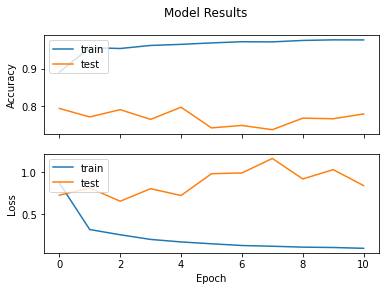

In [72]:
visualize_training_results(L1L2_history)

163/163 [==============================] - 1s 7ms/step - loss: 0.1650 - accuracy: 0.9664
Training Loss:0.165
Training Accuracy:0.9664
20/20 [==============================] - 0s 8ms/step - loss: 0.7237 - accuracy: 0.7981
Test Loss:0.7237
Test Accuracy:0.7981


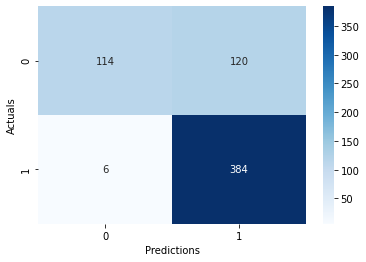

              precision    recall  f1-score   support

         0.0       0.95      0.49      0.64       234
         1.0       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



([0.9664], [0.7981])

In [74]:
L1L2_best = load_model('/content/saved_models/L1L2.h5')
L1L2_best_m = model_evaluation(L1L2_best)
L1L2_best_m

### 5) Padding

https://deepai.org/machine-learning-glossary-and-terms/padding#:~:text=In%20order%20to%20assist%20the,more%20accurate%20analysis%20of%20images.

In [75]:
padding = models.Sequential()
padding.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Flatten())
padding.add(layers.Dense(128, activation='relu'))
padding.add(layers.Dense(1, activation='sigmoid'))

padding.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [77]:
mc_padding = ModelCheckpoint(filepath='/content/saved_models/padding.h5', 
                             monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [78]:
padding_history = padding.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=[es, mc_padding],
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 15ms/step - loss: 0.4506 - accuracy: 0.7818 - val_loss: 1.0416 - val_accuracy: 0.7420

Epoch 00001: val_accuracy improved from -inf to 0.74199, saving model to /content/saved_models/padding.h5
Epoch 2/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0982 - accuracy: 0.9679 - val_loss: 0.6470 - val_accuracy: 0.8269

Epoch 00002: val_accuracy improved from 0.74199 to 0.82692, saving model to /content/saved_models/padding.h5
Epoch 3/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0838 - accuracy: 0.9693 - val_loss: 1.2191 - val_accuracy: 0.7276

Epoch 00003: val_accuracy did not improve from 0.82692
Epoch 4/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0644 - accuracy: 0.9799 - val_loss: 1.2064 - val_accuracy: 0.7628

Epoch 00004: val_accuracy did not improve from 0.82692
Epoch 5/50
163/163 [==============================] - 2s 14ms/step - loss: 0.0437 - accuracy: 0.986

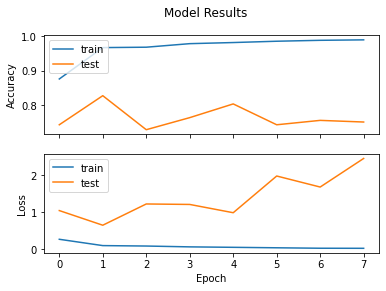

In [79]:
visualize_training_results(padding_history)

163/163 [==============================] - 1s 6ms/step - loss: 0.0798 - accuracy: 0.9703
Training Loss:0.07976
Training Accuracy:0.9703
20/20 [==============================] - 0s 7ms/step - loss: 0.6470 - accuracy: 0.8269
Test Loss:0.647
Test Accuracy:0.8269


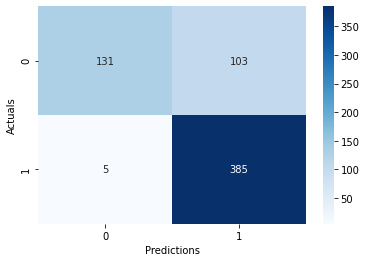

              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71       234
         1.0       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.85      0.83      0.81       624



([0.9703], [0.8269])

In [80]:
pad = load_model('/content/saved_models/padding.h5')
padd = model_evaluation(pad)
padd

>**Comment:** 
- The Padding took less time to run compare with the baseline model
- The train accuracy (0.9785) is higher than test accuracy (0.7804) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

#### Padding + L1

In [81]:
L1_padding = models.Sequential()
L1_padding.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(l1=0.005),
                          padding='same', activation='relu', input_shape=X_train.shape[1:]))
L1_padding.add(layers.MaxPooling2D((2, 2)))

L1_padding.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(l1=0.005),
                          padding='same', activation='relu'))
L1_padding.add(layers.MaxPooling2D((2, 2)))

L1_padding.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1(l1=0.005),
                          padding='same', activation='relu'))
L1_padding.add(layers.MaxPooling2D((2, 2)))

L1_padding.add(layers.Flatten())
L1_padding.add(layers.Dense(128, activation='relu'))
L1_padding.add(layers.Dense(1, activation='sigmoid'))

L1_padding.compile(optimizer='adam',
                  loss='binary_crossentropy',
                metrics=['accuracy'])

In [82]:
mc_L1_padding = ModelCheckpoint(filepath='/content/saved_models/L1_padding.h5', 
                               monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [84]:
L1_padding_history = L1_padding.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  callbacks=[es, mc_L1_padding],
                                  validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 16ms/step - loss: 6.9041 - accuracy: 0.8097 - val_loss: 1.1230 - val_accuracy: 0.7292

Epoch 00001: val_accuracy improved from -inf to 0.72917, saving model to /content/saved_models/L1_padding.h5
Epoch 2/50
163/163 [==============================] - 2s 14ms/step - loss: 0.5456 - accuracy: 0.9555 - val_loss: 0.9104 - val_accuracy: 0.7628

Epoch 00002: val_accuracy improved from 0.72917 to 0.76282, saving model to /content/saved_models/L1_padding.h5
Epoch 3/50
163/163 [==============================] - 2s 14ms/step - loss: 0.4051 - accuracy: 0.9510 - val_loss: 0.8153 - val_accuracy: 0.7788

Epoch 00003: val_accuracy improved from 0.76282 to 0.77885, saving model to /content/saved_models/L1_padding.h5
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.3099 - accuracy: 0.9647 - val_loss: 0.8614 - val_accuracy: 0.7548

Epoch 00004: val_accuracy did not improve from 0.77885
Epoch 5/50
163/163 [================

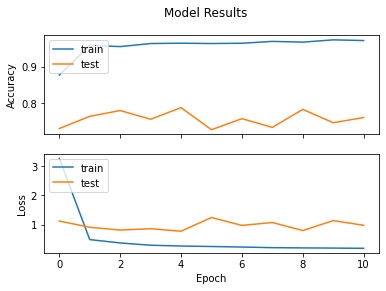

In [85]:
visualize_training_results(L1_padding_history)

163/163 [==============================] - 1s 6ms/step - loss: 0.2546 - accuracy: 0.9689
Training Loss:0.2546
Training Accuracy:0.9689
20/20 [==============================] - 0s 7ms/step - loss: 0.7759 - accuracy: 0.7869
Test Loss:0.7759
Test Accuracy:0.7869


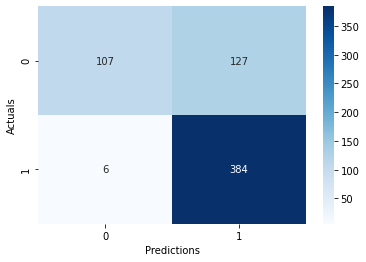

              precision    recall  f1-score   support

         0.0       0.95      0.46      0.62       234
         1.0       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.73       624
weighted avg       0.82      0.79      0.76       624



([0.9689], [0.7869])

In [86]:
L1pad = load_model('/content/saved_models/L1_padding.h5')
L1P = model_evaluation(L1pad)
L1P

### 6) Pretrained VGG19

In [87]:
from keras.applications import VGG19

In [88]:
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=X_train.shape[1:])

80142336/80134624 [==============================] - 1s 0us/step


In [89]:
pre = models.Sequential()
pre.add(pretrained)
pre.add(layers.Flatten())
pre.add(layers.Dense(128, activation='relu'))
pre.add(layers.Dense(1, activation='sigmoid'))

# Freeze pretained layer
pretrained.trainable = False

In [90]:
pre.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_96 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_192 (Dense)            (None, 128)               1048704   
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


In [91]:
# Verify "frozen"
for layer in pre.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_96 True
dense_192 True
dense_193 True


In [92]:
pre.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [94]:
mc_pre = ModelCheckpoint(filepath='/content/saved_models/pre.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [95]:
pre_history = pre.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      callbacks=[es, mc_pre],
                      validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 8s 39ms/step - loss: 0.3083 - accuracy: 0.8880 - val_loss: 0.5745 - val_accuracy: 0.8061

Epoch 00001: val_accuracy improved from -inf to 0.80609, saving model to /content/saved_models/pre.h5
Epoch 2/50
163/163 [==============================] - 5s 33ms/step - loss: 0.0894 - accuracy: 0.9683 - val_loss: 0.8483 - val_accuracy: 0.7676

Epoch 00002: val_accuracy did not improve from 0.80609
Epoch 3/50
163/163 [==============================] - 5s 33ms/step - loss: 0.0578 - accuracy: 0.9804 - val_loss: 0.8776 - val_accuracy: 0.7821

Epoch 00003: val_accuracy did not improve from 0.80609
Epoch 4/50
163/163 [==============================] - 5s 33ms/step - loss: 0.0610 - accuracy: 0.9763 - val_loss: 0.7219 - val_accuracy: 0.8253

Epoch 00004: val_accuracy improved from 0.80609 to 0.82532, saving model to /content/saved_models/pre.h5
Epoch 5/50
163/163 [==============================] - 5s 33ms/step - loss: 0.0331 - accuracy: 0.9884 - val_

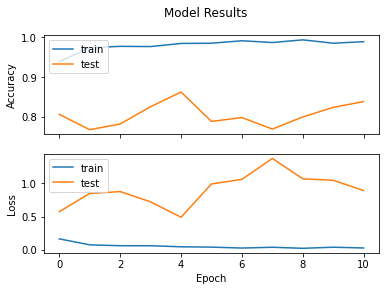

In [96]:
visualize_training_results(pre_history)

163/163 [==============================] - 5s 30ms/step - loss: 0.0852 - accuracy: 0.9659
Training Loss:0.08523
Training Accuracy:0.9659
20/20 [==============================] - 1s 30ms/step - loss: 0.4898 - accuracy: 0.8622
Test Loss:0.4898
Test Accuracy:0.8622


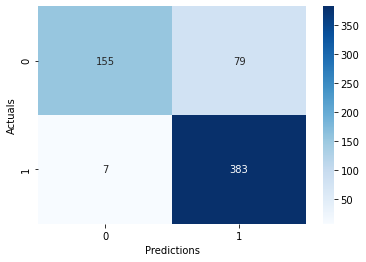

              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78       234
         1.0       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



([0.9659], [0.8622])

In [97]:
pret = load_model('/content/saved_models/pre.h5')
PRE = model_evaluation(pret)
PRE

## V. Evaluation

163/163 [==============================] - 5s 30ms/step - loss: 0.0852 - accuracy: 0.9659
Training Loss:0.08523
Training Accuracy:0.9659
20/20 [==============================] - 1s 30ms/step - loss: 0.4898 - accuracy: 0.8622
Test Loss:0.4898
Test Accuracy:0.8622


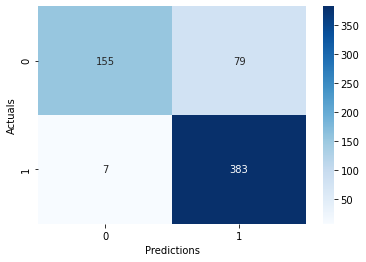

              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78       234
         1.0       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



([0.9659], [0.8622])

In [98]:
best = load_model('/content/saved_models/pre.h5')
BEST = model_evaluation(best)
BEST

In [99]:
best.evaluate(X_val, y_val)

1/1 [==============================] - 0s 41ms/step - loss: 0.1275 - accuracy: 0.9375


[0.1274668127298355, 0.9375]

In [100]:
# Predict for probability of getting 1
best.predict(X_val)

# predict_proba was deprecated

array([[0.999979],
       [0.122497],
       [0.974183],
       [0.035604],
       [0.996451],
       [0.007848],
       [0.001094],
       [0.997234],
       [0.833895],
       [0.002181],
       [0.999788],
       [0.999905],
       [0.000965],
       [0.971555],
       [0.000804],
       [0.997188]], dtype=float32)

In [101]:
# Flatten the array
prob = best.predict(X_val).flatten()
prob

array([0.999979, 0.122497, 0.974183, 0.035604, 0.996451, 0.007848,
       0.001094, 0.997234, 0.833895, 0.002181, 0.999788, 0.999905,
       0.000965, 0.971555, 0.000804, 0.997188], dtype=float32)

In [102]:
# Make prediction by using the best model
y_val_pred = ((best.predict(X_val) > 0.5).astype("int32")).flatten()
y_val_pred

# pad.predict_classes(X_val) was deprecated

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

In [103]:
y_act = y_val.astype("int32").flatten()
y_act

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

In [104]:
compare_df = pd.concat([pd.Series(y_act, name="Actual"),
                        pd.Series(y_val_pred, name="Predicted"),
                        pd.Series(prob, name="Probabilities")], axis=1)

In [105]:
compare_df

,Actual,Predicted,Probabilities
0,1,1,0.999979
1,0,0,0.122497
2,1,1,0.974183
3,0,0,0.035604
4,1,1,0.996451
5,0,0,0.007848
6,0,0,0.001094
7,1,1,0.997234
8,0,1,0.833895
9,0,0,0.002181


In [107]:
prob_test = best.predict(X_test).flatten()

In [108]:
y_test_pred = ((best.predict(X_test) > 0.5).astype("int32")).flatten()

In [110]:
y_test_act = y_test.astype("int32").flatten()

In [111]:
compare_test_df = pd.concat([pd.Series(y_test_act, name="Actual"),
                        pd.Series(y_test_pred, name="Predicted"),
                        pd.Series(prob_test, name="Probabilities")], axis=1)

In [112]:
compare_test_df

,Actual,Predicted,Probabilities
0,0,1,0.999631
1,1,1,0.999710
2,1,1,0.996480
3,0,0,0.000727
4,0,0,0.006031
...,...,...,...
619,1,1,0.999611
620,1,1,0.999876
621,1,1,0.999700
622,1,1,0.999995


In [113]:
compare_test_df.to_csv('/content/compare_test_df.csv')

In [114]:
compare_df.to_csv('/content/compare_val_df.csv')

## VI. Conclusion